# 7-ParallelEfficiency
This notebook evaluates the scaling of Dask, Spark, and DaskCuda dataframe libraries with respect to the number of cores and the file format of the data file ([csv](https://en.wikipedia.org/wiki/Comma-separated_values). vs. [parquet](https://parquet.apache.org/)). The executed notebooks with output and plots are saved in the [results directory](results). Note: this is not a representative comparison of these dataframe libraries.

See Robert Sinkovits' [Parallel Computing Concepts](https://github.com/sdsc/sdsc-summer-institute-2022/tree/main/2.1_parallel_computing_concepts) for background.

Author: Peter W. Rose (pwrose@ucsd.edu)

In [1]:
import os
import time
import math
import pandas as pd
import ipywidgets as widgets
import papermill as pm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

If LOCAL_SCRATCH_DIR environment variable is not set, this notebook accesses the ../data directory for temporary files.

In [2]:
DATA_DIR = os.getenv("LOCAL_SCRATCH_DIR", default="../data")
filename = os.path.join(DATA_DIR, "gene_info.tsv")
file_size = f"{os.path.getsize(filename)/1E9:.1f}"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
print(f"Filename: {filename}")
print(f"File Size: {file_size} GB")
print(f"Benchmark results directory: {RESULTS_DIR}")

Filename: ../data/gene_info.tsv
File Size: 5.4 GB
Benchmark results directory: results


### Setup Benchmark

#### Specify the number of cores to be used for benchmarking

In [4]:
# Cell has a ```parameters``` tag
n_cores = 8
file_format = "csv"

In [5]:
cores = [2**i for i in range(0, round(math.log2(n_cores)+1))]
print(cores)

[1, 2]


In [6]:
style = {'description_width': "initial"}
f_widget = widgets.RadioButtons(options=["csv", "parquet"], description="Select input file format:", value=file_format, style=style)
d_widget = widgets.RadioButtons(options=["Dask", "Spark", "DaskCuda (GPU)"], description="Select dataframe library:", value="Dask", style=style)

#### Select input format and dataframe library

In [7]:
display(f_widget, d_widget)

RadioButtons(description='Select input file format:', options=('csv', 'parquet'), style=DescriptionStyle(descr…

RadioButtons(description='Select dataframe library:', options=('Dask', 'Spark', 'DaskCuda (GPU)'), style=Descr…

In [8]:
file_format = f_widget.value
dataframe = d_widget.value
df_libraries = {"Dask": "3-DaskDataframe.ipynb", "Spark": "4-SparkDataframe.ipynb", "DaskCuda (GPU)": "6-DaskCudaDataframe.ipynb"}
notebook = df_libraries.get(dataframe)
notebook_name, _ = os.path.splitext(notebook)
output = f"{notebook_name}_{file_size}_{file_format}"

In [9]:
print(f"File format: {file_format}")
print(f"Dataframe  : {dataframe}")
print(f"Notebook   : {notebook}")

File format: csv
Dataframe  : Dask
Notebook   : 3-DaskDataframe.ipynb


### Run Benchmark
This benchmark runs Jupyter Notebooks with two input parameters: the number of ```cores``` and the ```file format``` of the input file. It uses [papermill](https://papermill.readthedocs.io/en/latest/) to execute the notebooks non-interactively. The executed notebooks with output and plots are saved in the [results directory](results).

In [10]:
timing = []
for n_cores in cores:
    start = time.time()

    notebook_out = os.path.join(RESULTS_DIR, f"{output}_{n_cores}.ipynb")
    
    pm.execute_notebook(notebook, notebook_out, parameters={"n_cores": n_cores, "file_format": file_format})
       
    end = time.time()
    
    print(f"cores: {n_cores}, time: {end-start:.1f} s, notebook: {notebook_out}")
    timing.append({"cores": n_cores, "time": end-start})

Executing:   0%|          | 0/24 [00:00<?, ?cell/s]

cores: 1, time: 90.6 s, notebook: results/3-DaskDataframe_5.4_csv_1.ipynb


Executing:   0%|          | 0/24 [00:00<?, ?cell/s]

cores: 2, time: 57.0 s, notebook: results/3-DaskDataframe_5.4_csv_2.ipynb


In [11]:
df = pd.DataFrame(timing)
df["efficiency"] = df["time"].iloc[0] / (df["time"] * df["cores"])
df["linear"] = df["time"].iloc[0] / df["cores"]
df

,cores,time,efficiency,linear
0,1,90.647607,1.000000,90.647607
1,2,56.976894,0.795477,45.323803


In [12]:
df.to_csv(os.path.join(RESULTS_DIR, f"{output}.csv"), index=False)

### Runtime and Parallel Efficiency as Function of Number of Cores

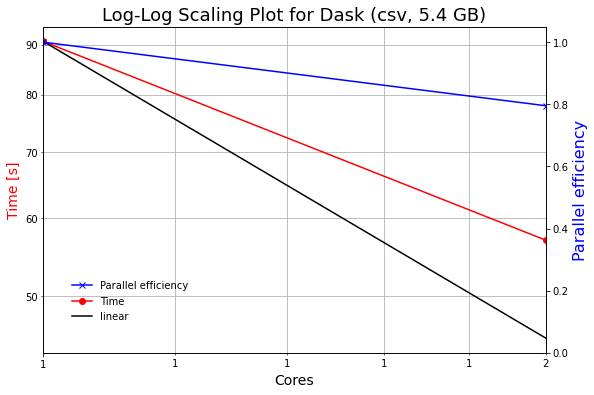

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog()
for axis in [ax.xaxis, ax.yaxis]:
    formatter = matplotlib.ticker.FormatStrFormatter("%d")
    axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)
ax.grid(visible=True, which='major', linewidth=2)
ax.grid(visible=True, which='minor')
plt.title(f"Log-Log Scaling Plot for {dataframe} ({file_format}, {file_size} GB)", fontsize=18)
plt.xlabel("Cores", fontsize=14)
plt.ylabel("Time [s]", fontsize=14, color='r')
plt.xlim([1, n_cores])
plt.plot(df["cores"].values, df["time"].values, 'ro-', label='Time')
ax.plot(df["cores"].values, df["linear"].values, 'k', label='linear')

ax2 = ax.twinx()
ax2.set_ylabel('Parallel efficiency', fontsize=16, color='b')
ax2.set_ylim(0, 1.05)
ax2.plot(df["cores"].values, df["efficiency"].values, 'bx-', label='Parallel efficiency')

ax.legend(loc='upper left', bbox_to_anchor=(0.04, 0.1, 0.1, 0.1), frameon=False)
ax2.legend(loc='upper left', bbox_to_anchor=(0.04, 0.15, 0.1, 0.1), frameon=False)


plt.savefig(os.path.join("results",f"{output}.png"), dpi=300)
plt.show()

* Time: observed runtime
* linear: expected runtime for perfect scaling
* Parallel efficiency: measure of resource utilization for parallel processing

For perfect scaling the observed runtime would match the linear black line and the parallel efficiency would be 1.0.
